# Gradual vs. Instant pruning

This file attempts to determine if gradual pruning is better than just pruning once (instant pruning). 

In [1]:
import torch
import torchvision as tv
import numpy as np
import matplotlib.pyplot as plt
from pytorch_resnet_cifar10 import resnet
import model_utils
import pruning

/home/zache1/anaconda3/envs/pyt/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading the data

To begin, we need to load the necessary data into a pytorch DataLoader. You can use multiple DataLoaders, as seen below, for training or testing data (you can also include validation data).

When running the below code, the data will be downloaded locally to '/data/CIFAR10'. It should create the folder if it is not there already

In [2]:
# perform the same transform on all the data
transform = tv.transforms.Compose(
    [tv.transforms.ToTensor(), # scale the data between 0..1
     tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # normalize the data

# get the cifar10 data
data_train = tv.datasets.CIFAR10(root="data/CIFAR10/train", train=True, download=True, transform=transform)
data_test = tv.datasets.CIFAR10(root="data/CIFAR10/test", train=False, download=True, transform=transform)

# create the dataloaders for each dataset. These will be used for training and getting accuracy of a model
dataloader_train = torch.utils.data.DataLoader(data_train, batch_size=128, shuffle=False)
dataloader_test = torch.utils.data.DataLoader(data_test, batch_size=128, shuffle=False)

print(np.shape(data_test.data))

Files already downloaded and verified
Files already downloaded and verified
(10000, 32, 32, 3)


Get the device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Function for loading the pre-trained model, sent to gpu if available, and prepares the model

In [4]:
def loadOriginalModel(device):
    model = resnet.resnet56()

    # load the model with the correct weights
    # must use DataParallel since the data was saved as a DataParallel
    torch.nn.DataParallel(model).load_state_dict(torch.load('pytorch_resnet_cifar10/pretrained_models/resnet56-4bfd9763.th', map_location=device)['state_dict'])

    model.to(device)

    model_utils.prepare_model(model)

    return model

Obtain the initial accuracy, the accuracy of the model out-of-the-box

In [5]:
model = loadOriginalModel(device)
initial_accuracy = model_utils.get_accuracy(model, dataloader_test, device)

# The Training Function

This function will be used to train the model.<br>
This uses L2 regularization with regularization value specified as 'weight_decay' in the initialization of 'optimizer'

In [6]:
def train(model, epochs, dataloader):
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.0001)

    for i in range(epochs):
        for (images, labels) in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
        print("\t\tEpoch: {}".format(i))

Set the target pruned percentages<br>
Set the target number of epochs<br>
Set how many times the program will run<br>

In [7]:
pruned_percentages = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95])
total_epochs = 120
iteration_times = 10

For simplicity sake, the total number of epochs should be a multiple of the amount of times pruning

In [8]:
assert total_epochs % np.size(pruned_percentages) == 0 

# Gradual pruning

The below code 
* takes a model
* repeatedly prunes and trains the model according to 'pruned_percentages' where each value is the next target prune
* acquires necessary data such as accuracy and the actual pruned percentage
* repeats all the above 'iteration_times' times. 

In [9]:
# obtain how much should be pruned between each pruning using the targeted pruned percentages
percent_per_prune = np.append(pruned_percentages[0], 1 - ((1 - pruned_percentages[1:]) / (1 - pruned_percentages[0:-1])))

gradual_accuracies = []
gradual_actual_pruned_percentages = []

# do this test multiple times
for _ in range(iteration_times):
    # get the original model
    model = loadOriginalModel(device)
    # determine how many times the model should be pruned
    times_pruned = np.size(percent_per_prune)
    # determine the number of epochs
    epochs = total_epochs // times_pruned
    accuracy = np.zeros(times_pruned)
    actual_pruned_percentage = np.zeros(times_pruned)
    for indx, percent in enumerate(percent_per_prune):
        pruning.global_mag_weight_prune(model, percent)
        train(model, epochs, dataloader_train)
        accuracy[indx] = model_utils.get_accuracy(model, dataloader_test, device)
        actual_pruned_percentage[indx] = model_utils.pruned_percentage(model, 'weight')
    gradual_accuracies.append(accuracy)
    gradual_actual_pruned_percentages.append(actual_pruned_percentage)

		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch: 5
		Epoch: 6
		Epoch: 7
		Epoch: 8
		Epoch: 9
		Epoch: 10
		Epoch: 11
		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch: 5
		Epoch: 6
		Epoch: 7
		Epoch: 8
		Epoch: 9
		Epoch: 10
		Epoch: 11
		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch: 5
		Epoch: 6
		Epoch: 7
		Epoch: 8
		Epoch: 9
		Epoch: 10
		Epoch: 11
		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch: 5
		Epoch: 6
		Epoch: 7
		Epoch: 8
		Epoch: 9
		Epoch: 10
		Epoch: 11
		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch: 5
		Epoch: 6
		Epoch: 7
		Epoch: 8
		Epoch: 9
		Epoch: 10
		Epoch: 11
		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch: 5
		Epoch: 6
		Epoch: 7
		Epoch: 8
		Epoch: 9
		Epoch: 10
		Epoch: 11
		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch: 5
		Epoch: 6
		Epoch: 7
		Epoch: 8
		Epoch: 9
		Epoch: 10
		Epoch: 11
		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch

# Instant pruning

The below code 
* takes a model
* prunes the model
* trains the model using the same number of epochs as the corresponding gradual pruning model
* obtains the data
* repeats all the above 'iteration_times' times. 

In [10]:
instant_accuracies = []
instant_actual_pruned_percentages = []

for _ in range(iteration_times):
    times_pruned = np.size(pruned_percentages)
    epochs = total_epochs // times_pruned
    epochs_increase = total_epochs // times_pruned
    accuracy = np.zeros(times_pruned)
    actual_pruned_percentage = np.zeros(times_pruned)
    for indx, percent in enumerate(pruned_percentages):
        model = loadOriginalModel(device)
        pruning.global_mag_weight_prune(model, percent)
        train(model, epochs, dataloader_train)
        epochs += epochs_increase # increase the total number of epochs to match the gradual pruning
        accuracy[indx] = model_utils.get_accuracy(model, dataloader_test, device)
        actual_pruned_percentage[indx] = model_utils.pruned_percentage(model, 'weight')
    instant_accuracies.append(accuracy)
    instant_actual_pruned_percentages.append(actual_pruned_percentage)

		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch: 5
		Epoch: 6
		Epoch: 7
		Epoch: 8
		Epoch: 9
		Epoch: 10
		Epoch: 11
		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch: 5
		Epoch: 6
		Epoch: 7
		Epoch: 8
		Epoch: 9
		Epoch: 10
		Epoch: 11
		Epoch: 12
		Epoch: 13
		Epoch: 14
		Epoch: 15
		Epoch: 16
		Epoch: 17
		Epoch: 18
		Epoch: 19
		Epoch: 20
		Epoch: 21
		Epoch: 22
		Epoch: 23
		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch: 5
		Epoch: 6
		Epoch: 7
		Epoch: 8
		Epoch: 9
		Epoch: 10
		Epoch: 11
		Epoch: 12
		Epoch: 13
		Epoch: 14
		Epoch: 15
		Epoch: 16
		Epoch: 17
		Epoch: 18
		Epoch: 19
		Epoch: 20
		Epoch: 21
		Epoch: 22
		Epoch: 23
		Epoch: 24
		Epoch: 25
		Epoch: 26
		Epoch: 27
		Epoch: 28
		Epoch: 29
		Epoch: 30
		Epoch: 31
		Epoch: 32
		Epoch: 33
		Epoch: 34
		Epoch: 35
		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch: 5
		Epoch: 6
		Epoch: 7
		Epoch: 8
		Epoch: 9
		Epoch: 10
		Epoch: 11
		Epoch: 12
		Epoch: 13
		Epoch:

In [11]:
print(gradual_accuracies)
print(instant_accuracies)

[array([0.9   , 0.8955, 0.8982, 0.8901, 0.8847, 0.8877, 0.8873, 0.8746,
       0.8649, 0.8632]), array([0.8945, 0.8953, 0.8961, 0.892 , 0.8921, 0.8879, 0.8882, 0.8928,
       0.8558, 0.856 ]), array([0.8999, 0.8922, 0.8858, 0.8911, 0.8885, 0.8923, 0.8929, 0.8913,
       0.8751, 0.8611]), array([0.899 , 0.8995, 0.8922, 0.8874, 0.8859, 0.883 , 0.8865, 0.8885,
       0.8614, 0.8567]), array([0.8973, 0.8921, 0.896 , 0.8947, 0.8845, 0.8887, 0.8909, 0.8855,
       0.8646, 0.8584]), array([0.8945, 0.896 , 0.8877, 0.8841, 0.8938, 0.885 , 0.8904, 0.8848,
       0.8633, 0.8606]), array([0.9011, 0.8883, 0.8904, 0.8882, 0.8939, 0.8895, 0.8871, 0.8865,
       0.8661, 0.8644]), array([0.8944, 0.8894, 0.888 , 0.8908, 0.8855, 0.8876, 0.892 , 0.8897,
       0.8584, 0.8588]), array([0.8959, 0.8909, 0.8954, 0.8874, 0.8843, 0.8841, 0.8919, 0.8861,
       0.8681, 0.8584]), array([0.8937, 0.8948, 0.8907, 0.8969, 0.8884, 0.89  , 0.8945, 0.8896,
       0.8663, 0.8611])]
[array([0.9006, 0.8934, 0.8947, 0.8893,

In [12]:
print(gradual_actual_pruned_percentages)
print(instant_actual_pruned_percentages)

[array([0.10000047, 0.20000094, 0.30000141, 0.40000188, 0.50000235,
       0.60000282, 0.70000212, 0.80000141, 0.90000071, 0.95000094]), array([0.10000047, 0.20000094, 0.30000141, 0.40000188, 0.50000235,
       0.60000282, 0.70000212, 0.80000141, 0.90000071, 0.95000094]), array([0.10000047, 0.20000094, 0.30000141, 0.40000188, 0.50000235,
       0.60000282, 0.70000212, 0.80000141, 0.90000071, 0.95000094]), array([0.10000047, 0.20000094, 0.30000141, 0.40000188, 0.50000235,
       0.60000282, 0.70000212, 0.80000141, 0.90000071, 0.95000094]), array([0.10000047, 0.20000094, 0.30000141, 0.40000188, 0.50000235,
       0.60000282, 0.70000212, 0.80000141, 0.90000071, 0.95000094]), array([0.10000047, 0.20000094, 0.30000141, 0.40000188, 0.50000235,
       0.60000282, 0.70000212, 0.80000141, 0.90000188, 0.95000094]), array([0.10000047, 0.20000094, 0.30000141, 0.40000188, 0.50000235,
       0.60000282, 0.70000212, 0.80000141, 0.90000071, 0.95000094]), array([0.10000047, 0.20000094, 0.30000141, 0.40

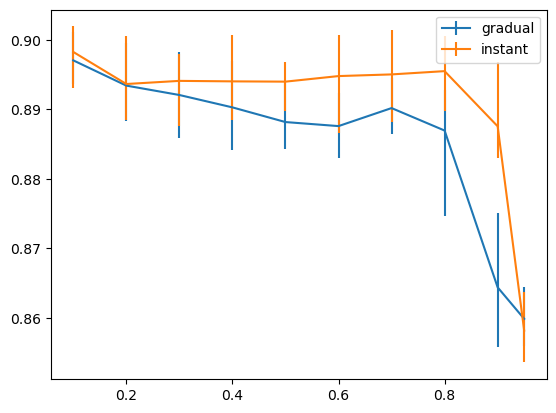

In [13]:
fig, ax = plt.subplots()
gradual_avg = np.mean(gradual_accuracies, axis=0)
gradual_max = np.max(gradual_accuracies, axis=0)
gradual_min = np.min(gradual_accuracies, axis=0)
ax.errorbar(gradual_actual_pruned_percentages[0], gradual_avg, yerr=(gradual_avg - gradual_min, gradual_max - gradual_avg), label="gradual")
instant_avg = np.mean(instant_accuracies, axis=0)
instant_max = np.max(instant_accuracies, axis=0)
instant_min = np.min(instant_accuracies, axis=0)
ax.errorbar(instant_actual_pruned_percentages[0], instant_avg, yerr=(instant_avg - instant_min, instant_max - instant_avg), label="instant")
ax.legend()